In [ ]:
#%env CUDA_VISIBLE_DEVICES=2

import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [ ]:
trainset = torchvision.datasets.FashionMNIST(root = "f://machine vision//code//dataset", train = True, download = True, transform = transforms.ToTensor())

Extracting f://machine vision//code//dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to f://machine vision//code//dataset/FashionMNIST/raw


Extracting f://machine vision//code//dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to f://machine vision//code//dataset/FashionMNIST/raw



Extracting f://machine vision//code//dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to f://machine vision//code//dataset/FashionMNIST/raw


Extracting f://machine vision//code//dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to f://machine vision//code//dataset/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
#loading the training data from trainset
batch_size = 128

#download the data again and set the train, test loader with different batch size
trainset = torchvision.datasets.FashionMNIST(root='f:/machine vision/code/dataset', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.FashionMNIST(root='f:/machine vision/code/dataset', train=False, download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
classes = ('T-Shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot')

In [ ]:
input_size = (1,28,28)

In [ ]:
# define our convolutional neural networks
class Net(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, 4)
        self.conv2 = nn.Conv2d(6, 6, 12)
        self.conv3 = nn.Conv2d(6, 12, 4)
        self.conv4 = nn.Conv2d(12, 12, 4)
        
        

        self.pool = nn.MaxPool2d(1,1) # kernel size 2x2, stride = 2

        n_size = self._get_conv_output(input_size)

        self.fc1 = nn.Linear(n_size, 192)
        self.fc2 = nn.Linear(192, 120)
        self.dropout = nn.Dropout(0.3)
        self.fc3 = nn.Linear(120, 60)
        self.fc4 = nn.Linear(60, num_classes)

        

    def _get_conv_output(self, shape):
      
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))
        output_feat = self._forward_features(input)
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size

    def _forward_features(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = self.pool(torch.nn.functional.relu(self.conv3(x)))
        x = self.pool(torch.nn.functional.relu(self.conv4(x)))
        return x
      
    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1) # flattening
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.dropout(x)
        x =torch.nn.functional.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [ ]:
input_size = (1,28,28)


In [ ]:
num_classes=len((classes))
print(num_classes)

10


In [ ]:
model = Net(input_size, num_classes)
model = model.to('cuda:0')

In [ ]:
model

Net(
  (conv1): Conv2d(1, 6, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(6, 6, kernel_size=(12, 12), stride=(1, 1))
  (conv3): Conv2d(6, 12, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(12, 12, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=768, out_features=192, bias=True)
  (fc2): Linear(in_features=192, out_features=120, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (fc3): Linear(in_features=120, out_features=60, bias=True)
  (fc4): Linear(in_features=60, out_features=10, bias=True)
)

In [ ]:
# Define Optimizer and Loss Function
learning_rate =0.00001
loss_func = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader, 0):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() 
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() 
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader,0):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() 

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() 
                
                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/(len(trainloader))
        avg_train_acc = train_acc/	(len(trainloader))

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/	(len(testloader))
        avg_valid_acc = valid_acc/	(len(testloader))

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
       # print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, 2, evaluation(testloader), evaluation(trainloader)))
        # Save if the model has best accuracy till now
        torch.save(model, 'f://machine vision//code//dataset'+'_model_'+str(epoch)+'.pt')

    
            
    return model, history
    

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Print the model to be trained
#summary(resnet50, input_size=(3, 224, 224), batch_size=bs, device='cuda')

# Train the model for 25 epochs
num_epochs = 50

trained_model, history = train_and_validate(model, loss_func, optimizer, num_epochs)

torch.save(history, 'f://machine vision//code//dataset'+'_history.pt')

Epoch: 1/50
Epoch : 000, Training: Loss: 2.2927, Accuracy: 11.0469%, 
		Validation : Loss : 2.2276, Accuracy: 24.1891%, Time: 7.0905s
Epoch: 2/50
Epoch : 001, Training: Loss: 1.7588, Accuracy: 41.2191%, 
		Validation : Loss : 1.3709, Accuracy: 54.0051%, Time: 7.0103s
Epoch: 3/50
Epoch : 002, Training: Loss: 1.2330, Accuracy: 56.8930%, 
		Validation : Loss : 1.1558, Accuracy: 58.4850%, Time: 7.1359s
Epoch: 4/50
Epoch : 003, Training: Loss: 1.0865, Accuracy: 60.0191%, 
		Validation : Loss : 1.0537, Accuracy: 60.8386%, Time: 7.0211s
Epoch: 5/50
Epoch : 004, Training: Loss: 1.0056, Accuracy: 61.8975%, 
		Validation : Loss : 0.9961, Accuracy: 62.1737%, Time: 7.0094s
Epoch: 6/50
Epoch : 005, Training: Loss: 0.9536, Accuracy: 63.1241%, 
		Validation : Loss : 0.9494, Accuracy: 63.0934%, Time: 7.1512s
Epoch: 7/50
Epoch : 006, Training: Loss: 0.9166, Accuracy: 64.3979%, 
		Validation : Loss : 0.9160, Accuracy: 64.4482%, Time: 7.1209s
Epoch: 8/50
Epoch : 007, Training: Loss: 0.8869, Accuracy: 65.

79


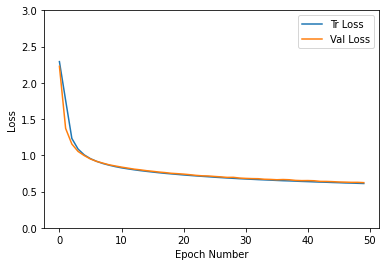

In [ ]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
print(len(testloader))
plt.show()


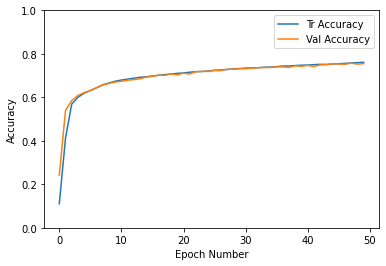

In [ ]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)

plt.show()